### Project Abstract ###

**Situation** The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies. The objective of this project is to explore different machine learning techniques and identify an optimized model that can help the marketing team understand customer behavior and make informed decisions.

**Task** The challenge is to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. Hopefully this exploration will lead to actionable insights and help allocating marketing budgets for those companies who choose to use data analysis on top of GA data.

**Action** This exploration is based on a Kaggle competition and there are two datasets available in Kaggle. One is the test dataset (test.csv) and the other one is the training dataset (train.csv) and together the datasets contain customer transaction information ranging from August 2016 to April 2018. The action plan for this project is to first conduct data exploration that includes but not limited to investigating the statistics of data, examining the target variable distribution and other data distributions visually, determining imputation strategy based on the nature of missing data, exploring different techniques to scale the data, identifying features that may not be needed - for example, columns with constant variance, exploring different encoding techniques to convert categorical data to numerical data and identifying features with high collinearity. The preprocessed data will then be trained using a linear regression model with basic parameter setting and K-Fold cross validation. Based on the outcome of this initial model further experimentation will be conducted to tune the hyper parameters including regularization and also add new derived features to improve the accuracy of the model. Apart from linear regression other machine learning techniques like ensemble methods will be explored and compared.

**Result** The best performing model determined based on the RMSE value will be used in the inference process to predict the revenue per customer. The Kaggle competition requires to predict the natural log of sum of all transactions per customer

### Datasets ###

As mentioned in the earlier sections, the dataset used in this model exploration was downloaded from Kaggle [^1] and available in CSV file format. The training contains more than 872K observations and based on the size of the dataset it would be ideal to use mini-batch or gradient descent optimization techniques to identify the coefficients that best describe the model. The target variable as observed in the dataset is a continuous variable which implies that the use case is a regression problem. As mentioned earlier, there are several machine learning techniques that can be explored for this type of problem including regression and ensemble methods with different parameter settings. The sparsity of potential features in the datasets indicates that multiple experimentations will be required to determine the best performing model. Also based on initial review of the datasets, it also observed that some of the categorical features exhibit low to medium cardinality and if these features are going to be retained in the final dataset used for training then it is important to choose the right encoding technique.

Train.csv User transactions from August 1st, 2016 to August 1st, 2017

Test.csv User transactions from August 2nd, 2017 to April 30th, 2018 

### Import Libraries ##

Importing all the required Libraries required for this project

In [19]:
##Importing required libraries
import os
import time
import gc
import warnings
warnings.filterwarnings("ignore")
# data manipulation
import json
from pandas.io.json import json_normalize
import numpy as np
import pandas as pd
import pandas_profiling
# plot
import matplotlib.pyplot as plt
import seaborn as sns
from cloudmesh.common.StopWatch import StopWatch
from cloudmesh.common.Benchmark import Benchmark
import time
color = sns.color_palette()

Mounting Google Drive to Access the datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# Navigate to My Drive directory to store the dataset
%cd /content/drive/My Drive/Colab Notebooks/NLP_GStore/ProjectFinal/

Mounted at /content/drive


### Data Load Function ###

Function to load the data from the folder.Loads the data and flattens the JSON Columns such as Device, GeoNetwork, Totals, TrafficCource etc

In [20]:
%%time
Benchmark.Start()
def load_dataframe(csv_path='train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df
Benchmark.Stop()

gc.collect()

CPU times: user 102 ms, sys: 9.21 ms, total: 111 ms
Wall time: 112 ms


In [21]:
# Dataframe contains 903.6K Rows and 55 Cols in Training
# Dataframe contains 804.7K Rows and 53 Cols in Testing
traindf = load_dataframe('https://storage.googleapis.com/gstoretrain/train.csv')
testdf = load_dataframe('https://storage.googleapis.com/gstoretrain/test.csv')

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)


In [22]:
Benchmark.print()


+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | bionic                                                           |
| DISTRIB_DESCRIPTION | "Ubuntu 18.04.5 LTS"                                             |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 18.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           

### Preliminary Data Statistics ###

Let's take a look at the dataset using the head() command

In [ ]:
# Taking a peek at the data. Below command displays first 5 rows
traindf.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

In [ ]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    903653 non-null  object
 1   date                                               903653 non-null  int64 
 2   fullVisitorId                                      903653 non-null  object
 3   sessionId                                          903653 non-null  object
 4   socialEngagementType                               903653 non-null  object
 5   visitId                                            903653 non-null  int64 
 6   visitNumber                                        903653 non-null  int64 
 7   visitStartTime                                     903653 non-null  int64 
 8   device.browser                                     903653 non-null  object
 9   devi

#### Sweetviz Exploration ####

Sweetviz is an automated Exploratoratory Data Analysis package that helps to quicky get the summaries, distributions and missing value information from the dataset 

In [ ]:
import sweetviz as sv

my_report = sv.analyze(traindf)
my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"
#Renamed this report to Initial_Analysis_Report.html
#The report contains the basic exploratory data analysis with plot distributions for individual independent variables

:FEATURES DONE:                    |█████████████████████| [100%]   01:05  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   35:59  -> (00:00 left)


Creating Associations graph... DONE!
Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.


### Exploratory Data Analysis ###

#### Target Variable Distribution ####

Perform basic analysis on the Target variable: totals.transactionRevenue

In [23]:
y = np.nan_to_num(np.array([float(i) for i in traindf['totals.transactionRevenue']]))
print('The ratio of customers with transaction revenue is', str((y != 0).mean()))   

The ratio of customers with transaction revenue is 0.0127427231470487


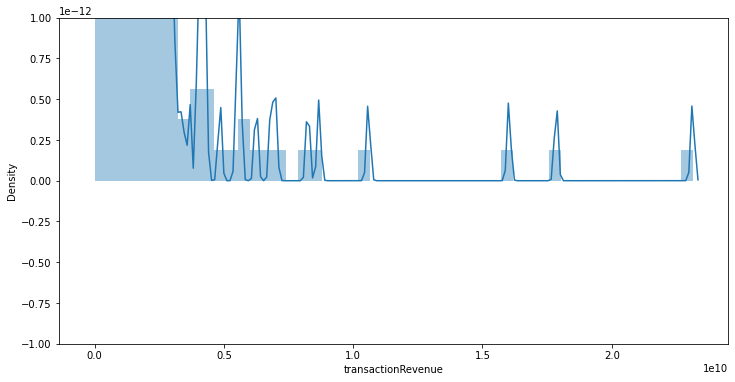

In [25]:
%matplotlib inline
plt.figure(figsize=[12, 6])
sns.distplot(y[y!=0])
plt.xlabel('transactionRevenue')
plt.show()

The Target Variable above has multiple peaks and doesn't follow a Normal Distribution. In the next step, I will perform the lognnormal transformation, so the Target Variable will have a Normal Distribution

In [26]:
traindf["totals.transactionRevenue"] = traindf["totals.transactionRevenue"].astype('float')
target = np.log1p(traindf.groupby("fullVisitorId")["totals.transactionRevenue"].sum())
print('The ratio of customers with transaction revenue is', str((target != 0).mean()))

The ratio of customers with transaction revenue is 0.013996726255903731


Visualizing the Target Variable after the transformation and appears that the target variable now has a normal distribution

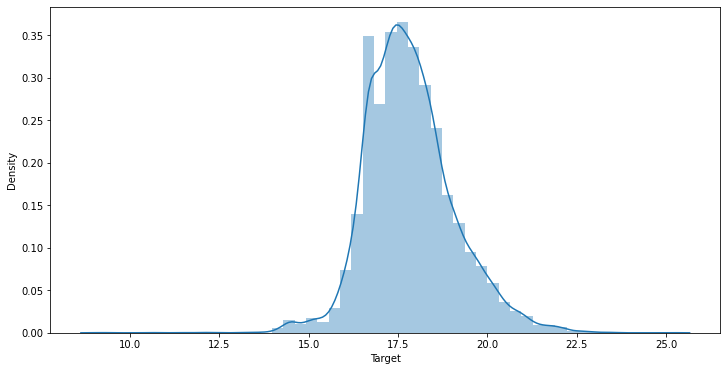

In [27]:
plt.figure(figsize=[12, 6])
sns.distplot(target[target!=0])
plt.xlabel('Target')
plt.show()

#### Function to plot categorical data ####

Plot_Categorical Function will take column name as an input paramter, along with additional paramters such as Title, Size, and xlabel angle and produce results accordingly. 

In [28]:
def plot_categorical(data, col, size=[8 ,4], xlabel_angle=0, title='', max_cat = None):
    '''use this for ploting the count of categorical features'''
    plotdata = data[col].value_counts() / len(data)
    if max_cat != None:
        plotdata = plotdata[max_cat[0]:max_cat[1]]
    plt.figure(figsize = size)
    sns.barplot(x = plotdata.index, y=plotdata.values)
    plt.title(title)
    if xlabel_angle!=0: 
        plt.xticks(rotation=xlabel_angle)
    plt.show()

#### Device Group distribution ####

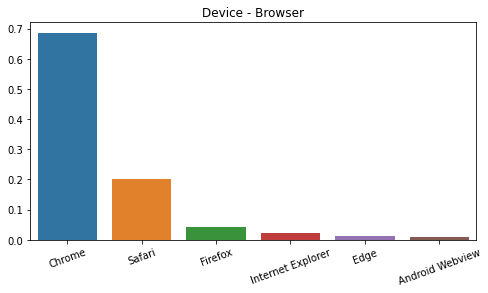

In [29]:
plot_categorical(data=traindf, col='device.browser', size=[8 ,4], xlabel_angle=20, title='Device - Browser', max_cat=[0, 6])

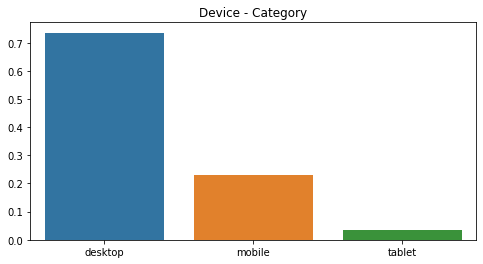

In [30]:
plot_categorical(data=traindf, col='device.deviceCategory', size=[8 ,4], xlabel_angle=0, title='Device - Category')

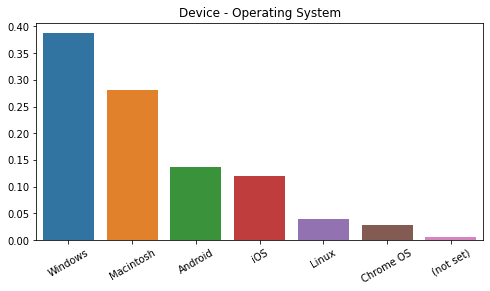

In [31]:
plot_categorical(data=traindf, col='device.operatingSystem', size=[8 ,4], xlabel_angle=30, 
                 title='Device - Operating System', max_cat = [0, 7])

From the above plots it looks like most of the customers are suing Windows Desktop, Chrome to visit the Online store. Second popular combination is Mac desktop with either Chrome or Safari

The below plots are specific to the Geography of Users who are accessing the Online Store. From the below plots, its clear that majority of the users are in US and Califonia cities heavily visit online stores

#### Geo Network Group distribution ####

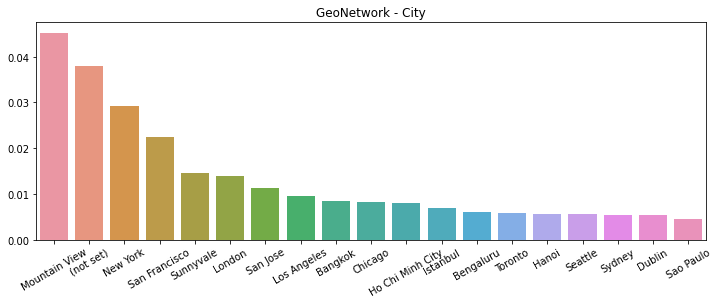

In [32]:
plot_categorical(data=traindf, col='geoNetwork.city', size=[12 ,4], xlabel_angle=30, 
                 title='GeoNetwork - City', max_cat = [1, 20])

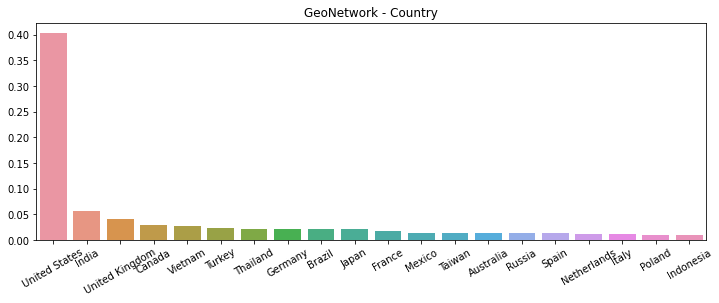

In [33]:
plot_categorical(data=traindf, col='geoNetwork.country', size=[12 ,4], xlabel_angle=30, 
                 title='GeoNetwork - Country', max_cat = [0, 20])

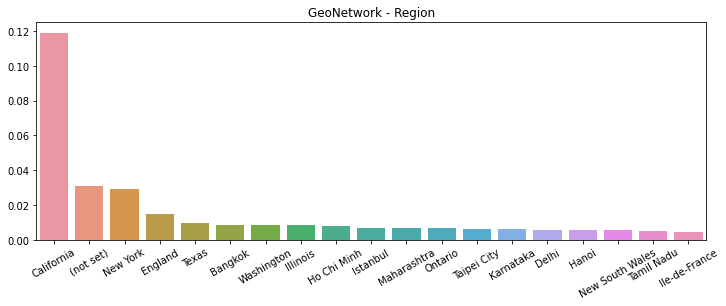

In [34]:
plot_categorical(data=traindf, col='geoNetwork.region', size=[12 ,4], xlabel_angle=30, 
                 title='GeoNetwork - Region', max_cat = [1, 20])

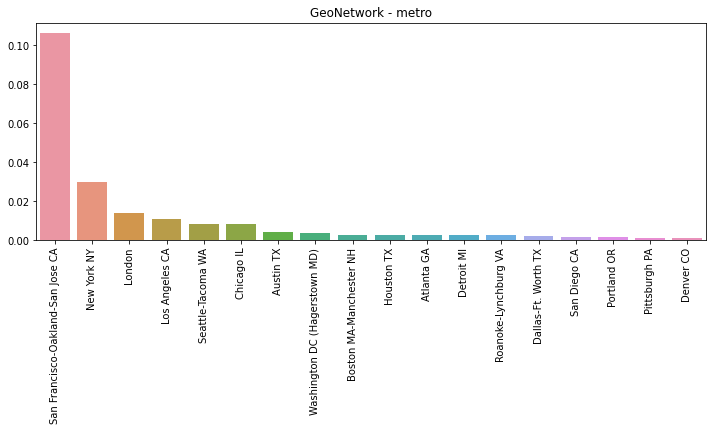

In [35]:
plot_categorical(data=traindf, col='geoNetwork.metro', size=[12 ,4], xlabel_angle=90, 
                 title='GeoNetwork - metro', max_cat = [2, 20])

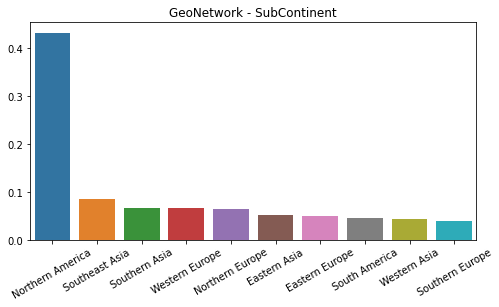

In [36]:
plot_categorical(data=traindf, col='geoNetwork.subContinent', size=[8 ,4], xlabel_angle=30, 
                 title='GeoNetwork - SubContinent', max_cat = [0, 10])

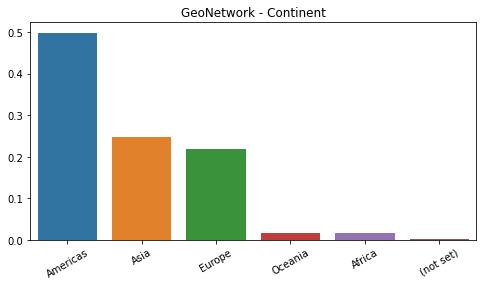

In [37]:
plot_categorical(data=traindf, col='geoNetwork.continent', size=[8 ,4], xlabel_angle=30, 
                 title='GeoNetwork - Continent')

#### Totals Group Distribution ####

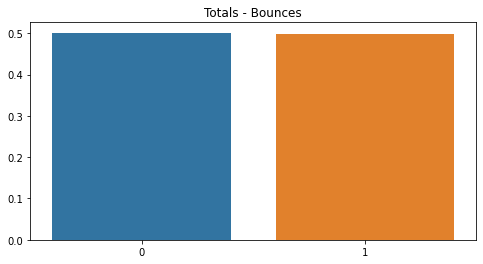

In [38]:
traindf['totals.bounces'] = traindf['totals.bounces'].fillna('0')
plot_categorical(data=traindf, col='totals.bounces', size=[8 ,4], xlabel_angle=0, title='Totals - Bounces')

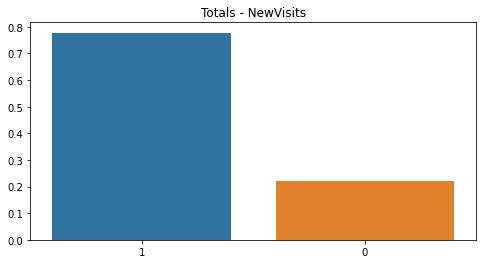

In [39]:
traindf['totals.newVisits'] = traindf['totals.newVisits'].fillna('0')
plot_categorical(data=traindf, col='totals.newVisits', size=[8 ,4], xlabel_angle=0, title='Totals - NewVisits')

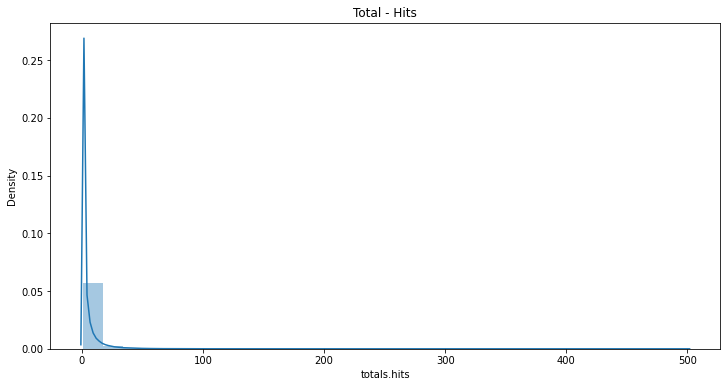

In [40]:
plt.figure(figsize=[12, 6])
sns.distplot(traindf['totals.hits'].astype('float'), kde=True,bins=30)
plt.xlabel('totals.hits')
plt.title('Total - Hits')
plt.show()

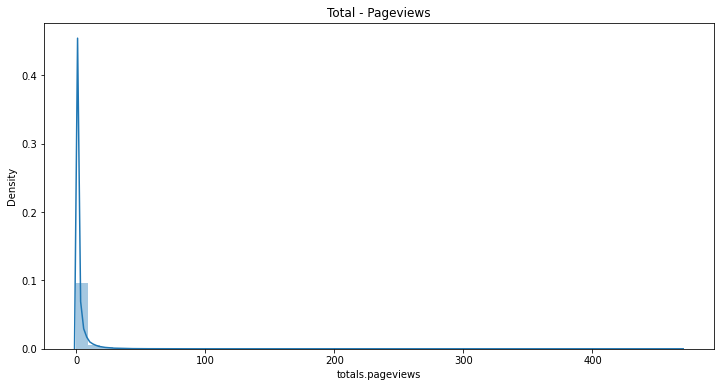

In [ ]:
plt.figure(figsize=[12, 6])
sns.distplot(traindf['totals.pageviews'].astype('float').fillna(0))
plt.xlabel('totals.pageviews')
plt.title('Total - Pageviews')
plt.show()

#### Traffic Source Group distribution ####

From the below plots it can be noticed that, Google Merchandise Store and Google Online Store are the top sources for AdContent

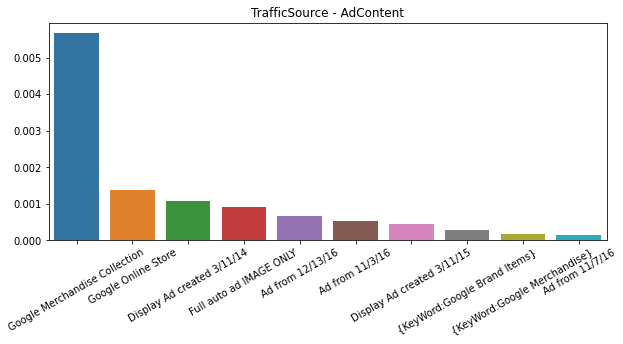

In [ ]:
plot_categorical(data=traindf, col='trafficSource.adContent', size=[10 ,4], xlabel_angle=30, 
                 title='TrafficSource - AdContent', max_cat = [0, 10])

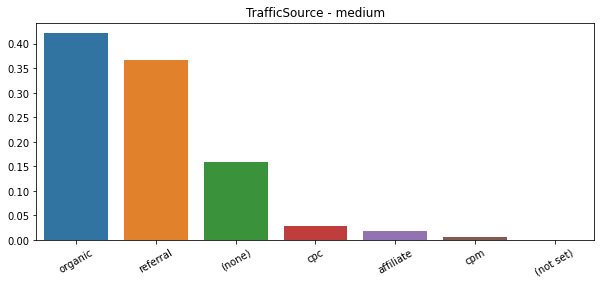

In [41]:
plot_categorical(data=traindf, col='trafficSource.medium', size=[10 ,4], xlabel_angle=30, 
                 title='TrafficSource - medium')

#### Other Group distributions ####

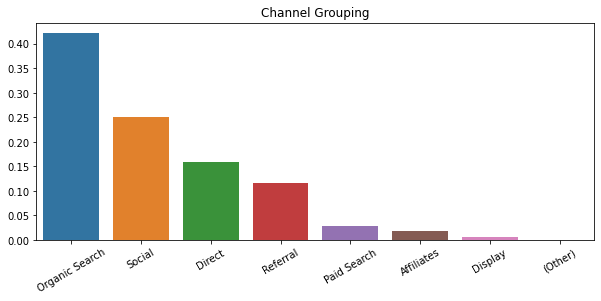

In [ ]:
plot_categorical(data=traindf, col='channelGrouping', size=[10 ,4], xlabel_angle=30, 
                 title='Channel Grouping')

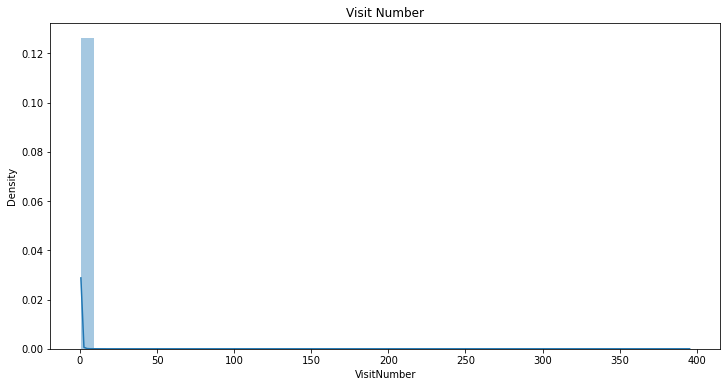

In [ ]:
a = traindf.groupby("fullVisitorId")["visitNumber"].max()
plt.figure(figsize=[12, 6])
sns.distplot(a)
plt.xlabel('VisitNumber')
plt.title('Visit Number')
plt.show()

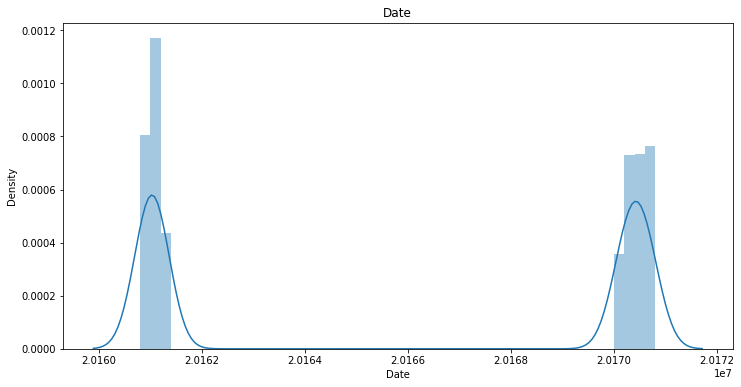

In [ ]:
plt.figure(figsize=[12, 6])
sns.distplot(traindf['date'])
plt.xlabel('Date')
plt.title('Date')
plt.show()

### Data Pre-Processing and Feature Engineering ###

#### Helper Classes for Pre-processing and Feature Engineering ####

We created the DataFrameSelector class to create a custom transformer to handle numerical and categorical columns to perform fit and transform operations and it helps to make our code scalable and helps in building overall a better pipeline 

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

The CategoricalEncoder class we created below will perform the Label Encoding operations and by creating a class, we are isolating the logic and we can utilize in the overall data pipeline. 

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols):
        self.cat_cols=cat_cols
        return None
    def fit(self, X, y=None):
        self.X=X
        return self
    def transform(self, X):
        X = pd.DataFrame(X)
        X.columns = self.cat_cols
        for col in self.cat_cols:
            lbl = LabelEncoder()
            lbl.fit(list(X[col].values.astype('str')))
            X[col] = lbl.transform(list(X[col].values.astype('str')))
        return X

**Feature Extraction Functions**

We create several functions to help us with the feature extraction procedure. The functions are explained in the comments section on every function 

In [44]:
def process_date_time(data_df):
    #Extract date related values such as month, year, day from the "Date" variables
    print("process date time ...")
    data_df['date'] = data_df['date'].astype(str)
    data_df["date"] = data_df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    data_df["date"] = pd.to_datetime(data_df["date"])   
    data_df["year"] = data_df['date'].dt.year
    data_df["month"] = data_df['date'].dt.month
    data_df["day"] = data_df['date'].dt.day
    data_df["weekday"] = data_df['date'].dt.weekday
    data_df['weekofyear'] = data_df['date'].dt.weekofyear
    data_df['month_unique_user_count'] = data_df.groupby('month')['fullVisitorId'].transform('nunique')
    data_df['day_unique_user_count'] = data_df.groupby('day')['fullVisitorId'].transform('nunique')
    data_df['weekday_unique_user_count'] = data_df.groupby('weekday')['fullVisitorId'].transform('nunique')
    return data_df

def process_format(data_df):
    #Convert the below features to FLoat and handle the missing values
    print("process format ...")
    for col in ['visitNumber', 'totals_hits', 'totals_pageviews']:
        data_df[col] = data_df[col].astype(float)
    data_df['trafficSource_adwordsClickInfo_isVideoAd'].fillna(True, inplace=True)
    data_df['trafficSource_isTrueDirect'].fillna(False, inplace=True)
    return data_df

def process_device(data_df):
    #Combine some of the features as they are more redundant. Instead of removing we are combining, so 
    #we can remove the redundancy at the sametime not lose any preditive power
    print("process device ...")
    data_df['browser_category']        = data_df['device_browser'] + '_' + data_df['device_deviceCategory']
    data_df['browser_operatingSystem'] = data_df['device_browser'] + '_' + data_df['device_operatingSystem']
    data_df['source_country']          = data_df['trafficSource_source'] + '_' + data_df['geoNetwork_country']
    return data_df
    
def process_totals(data_df):
    #Feature Engineering: Create mean, sum, max, min, variance for Total Variable   
    print("process totals ...")
    data_df['visitNumber']       = np.log1p(data_df['visitNumber'])
    data_df['totals_hits']       = np.log1p(data_df['totals_hits'])
    data_df['totals_pageviews']  = np.log1p(data_df['totals_pageviews'].fillna(0))
    data_df['mean_hits_per_day'] = data_df.groupby(['day'])['totals_hits'].transform('mean')
    data_df['sum_hits_per_day']  = data_df.groupby(['day'])['totals_hits'].transform('sum')
    data_df['max_hits_per_day']  = data_df.groupby(['day'])['totals_hits'].transform('max')
    data_df['min_hits_per_day']  = data_df.groupby(['day'])['totals_hits'].transform('min')
    data_df['var_hits_per_day']  = data_df.groupby(['day'])['totals_hits'].transform('var')
    return data_df

def process_geo_network(data_df):
    #Feature Engineering: Create mean, sum, max, min, variance for Total-hits and Totals_Pageviews Variable 
    print("process geo network ...")
    data_df['sum_pageviews_per_network_domain']   = data_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('sum')
    data_df['count_pageviews_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('count')
    data_df['mean_pageviews_per_network_domain']  = data_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('mean')
    data_df['sum_hits_per_network_domain']        = data_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('sum')
    data_df['count_hits_per_network_domain']      = data_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('count')
    data_df['mean_hits_per_network_domain']       = data_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('mean')
    return data_df

**Pre-processing and Feature Engineering Orchestrator Class**

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
class AttributesPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return None
    def fit(self, X, y=None):
        print("Fitting Data...")
        return self  # nothing else to do
    def transform(self, X, y=None):
        print("Transforming Data...")
        
        #Perform Imputation for the below mentioned variables
        X['totals_newVisits'].fillna(0,inplace=True) 
        X['totals_bounces'].fillna(0,inplace=True)
        X['trafficSource_adwordsClickInfo_page'].fillna(0,inplace=True)
        X['trafficSource_isTrueDirect'].replace({np.nan:0,'true':1},inplace=True)
        X['totals_bounces']   = X['totals_bounces'].fillna(0.0)
        X['totals_newVisits'] = X['totals_newVisits'].fillna(0.0)
        
        #Feature Engineering     
        X = process_date_time(X)
        X = process_format(X)
        X = process_device(X)
        X = process_totals(X)
        X = process_geo_network(X)
        
        #Drop Columns that has No Variance in the data
        cols_to_drop = [col for col in train_df.columns if train_df[col].nunique(dropna=False) == 1 and 
                        col not in ['totals_transactionRevenue','date']]
        X.drop(cols_to_drop, axis=1, inplace=True)
    
        #Column with mostly NULL value and only one NOT NULL value
        if 'trafficSource_campaign' in X.columns:
             X.drop(['trafficSource_campaign'], axis=1, inplace=True)
    
        return X

**Data Preparation**

Setup X_train and y_train that will be used in the Scikit Learn Train/Test model

In [48]:
train_df = traindf.copy()
train_df.columns = traindf.columns.str.replace(".","_")
train_df = train_df.sort_values('date')

#Prepare Target Variable
train_df['totals_transactionRevenue'] = train_df['totals_transactionRevenue'].astype(float)
train_df['totals_transactionRevenue'] = train_df['totals_transactionRevenue'].fillna(0)
train_df['totals_transactionRevenue'] = np.log1p(train_df['totals_transactionRevenue'])
X_train = train_df.drop('totals_transactionRevenue',axis=1)
y_train = train_df['totals_transactionRevenue']

#### Invoke Orchestration Class ####


In [47]:
X_train_copy = X_train.copy()

In [49]:
Benchmark.Start()
X_train = AttributesPreprocessor().fit_transform(X_train,y_train)
Benchmark.Stop()

Fitting Data...
Transforming Data...
process date time ...
process format ...
process device ...
process totals ...
process geo network ...


In [50]:
Benchmark.print()


+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | bionic                                                           |
| DISTRIB_DESCRIPTION | "Ubuntu 18.04.5 LTS"                                             |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 18.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           

#### Split the data using standard function ####

In [51]:
from sklearn.model_selection import train_test_split
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### Build the full SKLearn pipeline ####

*   The below steps builds the required data pipeline for the project. We identify numeric columns manually. We then specify the columns that aren't numeric are categorical colums and identify the categorical columns
*   For the numeric column and catagorical columns we setup the data pipeline accordingly
*   Full pipeline is setup by callgin the numeric pipeline and Categorical pipeline





In [52]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
num_cols = ['month_unique_user_count', 'day_unique_user_count', 'weekday_unique_user_count','visitNumber', 'totals_hits', 'totals_pageviews', 
            'mean_hits_per_day', 'sum_hits_per_day', 'min_hits_per_day', 'max_hits_per_day', 'var_hits_per_day',
            'sum_pageviews_per_network_domain', 'count_pageviews_per_network_domain', 'mean_pageviews_per_network_domain',
            'sum_hits_per_network_domain', 'count_hits_per_network_domain', 'mean_hits_per_network_domain']
cols_to_drop = [col for col in train_df.columns if train_df[col].nunique(dropna=False) == 1 and  col not in ['totals_transactionRevenue','date']]
cat_cols     = [col for col in X_train.columns if col not in num_cols and  col not in cols_to_drop and col not in 'trafficSource_campaign']
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_cols)),
        ('std_scaler', MinMaxScaler())
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_cols)),
        ('cat_encoder', CategoricalEncoder(cat_cols))
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline)
    ])

### Model Building and Cross Validation using Grid Search ###

### Linear Regression ###

#### Linear Regression - Model Preparation step ####

1.   Specify the LinearRegression in the sklearn pipeline function 
2.   Provide the Pipeline as an input to the Pipeline class



In [53]:
from sklearn.linear_model import LinearRegression
print("prepare model...")
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ("linRegression", LinearRegression())
])

prepare model...


#### Grid Search and Fit data ####

Setting up the Gridsearch along (not too many for Linear Regression), and calling the GridSearchCV Class with 5 fold CV to perform Training

In [54]:
Benchmark.Start()
from sklearn.model_selection import GridSearchCV
param_grid = {
    'linRegression__fit_intercept'     : [True,False],
    'linRegression__n_jobs'            : [-1]
}
grid_search_prep_LR = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search_prep_LR.fit(X_train_split, y_train_split)
Benchmark.Stop()

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.4min finished


In [55]:
Benchmark.print()


+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | bionic                                                           |
| DISTRIB_DESCRIPTION | "Ubuntu 18.04.5 LTS"                                             |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 18.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           

#### Grid Search Results ####

In [56]:
pd.DataFrame(grid_search_prep_LR.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linRegression__fit_intercept,param_linRegression__n_jobs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,125.838077,3.514977,30.848582,2.451899,True,-1,"{'linRegression__fit_intercept': True, 'linReg...",-3.577546,-3.878679,-3.481699,-3.496584,-3.423469,-3.571595,0.161236,1
1,110.221509,21.976129,25.176262,6.728731,False,-1,"{'linRegression__fit_intercept': False, 'linRe...",-8.552031,-4.217642,-8.742225,-8.016377,-7.721763,-7.450008,1.656931,2


#### Predict using Best LR Model ####

The grid serach provides the list of all the models. The function is used to predict the target variable using the test dataset, that was split using the Train_Test_Split function from SkLearn.



In [57]:
Benchmark.Start()
results = pd.DataFrame(columns=["Model description", "Best Params", "Best RMSE Score", "Train RMSE","Test RMSE", "Train Time", "Test Time"])
pd.set_option('display.max_colwidth', 0)

import time
start = time.time()
grid_search_prep_LR.best_estimator_.fit(X_train_split,y_train_split)
y_train_pred = grid_search_prep_LR.best_estimator_.predict(X_train_split)
train_time = time.time() - start
start = time.time()
y_test_pred = grid_search_prep_LR.best_estimator_.predict(X_test_split)
test_time = time.time() - start

# add the result of this experiment ot the log book
results.loc[len(results)] = ["SKLearn Linear Regression Best Model",
                            grid_search_prep_LR.best_params_,
                            np.round(np.sqrt(-1 * grid_search_prep_LR.best_score_), 3),
                            np.round(np.sqrt(((y_train_split-y_train_pred)**2).mean()), 3),
                            np.round(np.sqrt(((y_test_split-y_test_pred)**2).mean()), 3),
                            train_time,
                            test_time]
Benchmark.Stop()

The LR Model has a RMSE Score of **1.89**. The Train and Test RMSE Scores are close enough, that implies no overfitting in the model results

In [59]:
results

,Model description,Best Params,Best RMSE Score,Train RMSE,Test RMSE,Train Time,Test Time
0,SKLearn Linear Regression Best Model,"{'linRegression__fit_intercept': True, 'linRegression__n_jobs': -1}",1.89,1.847,1.889,228.275228,27.941794


In [58]:
Benchmark.print()


+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | bionic                                                           |
| DISTRIB_DESCRIPTION | "Ubuntu 18.04.5 LTS"                                             |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 18.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           

### XGBoost Regressor ###

#### Set Parameters ####

Import and Initialize xgboost

In [60]:
import xgboost as xgb
param = {
    'max_depth': 8,  # tried 2,4,6 & 8
    'eta': 0.01,  
    'silent': 1,  
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'subsample': 0.6,
    'colsample_bytree': 0.8,
    'alpha':0.01,
    'num_leaves' : 40,
    'random_state': 42} 

#### Build Model Pipeline ####

In [61]:
prepare_select_and_pipeline = Pipeline([
    ('preparation', full_pipeline)])
X_train_d=prepare_select_and_pipeline.fit_transform(X_train_split)
X_test_d=prepare_select_and_pipeline.fit_transform(X_test_split)
feature_names = X_train_split.columns

#### Split data and Train Model ####

Split the Training Data and perform model training and construct the xgb matrix that is the required format by the xgb model to train the data

Note: We tried to use CV but unfortunately the system kept running out of memory. So we aren't using any CV for XGBoose

In [62]:
X_train_split_tr, X_train_val, y_train_split_tr, y_train_val = train_test_split(X_train_d, y_train_split, test_size=0.2, random_state=42)
X_train_tr_data = xgb.DMatrix(X_train_split_tr,label=y_train_split_tr,feature_names=feature_names)
X_val_data = xgb.DMatrix(X_train_val,label=y_train_val,feature_names=feature_names)

In [63]:
Benchmark.Start()
import time
start = time.time()
xgb_model = xgb.train(param, X_train_tr_data, evals=[(X_train_tr_data, 'train'), (X_val_data, 'valid')], num_boost_round=2500, early_stopping_rounds=800, verbose_eval=1000)
train_time = time.time()-start
Benchmark.Stop()

[0]	train-rmse:2.00954	valid-rmse:2.03174
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 800 rounds.
[1000]	train-rmse:1.36244	valid-rmse:1.61998
Stopping. Best iteration:
[818]	train-rmse:1.39367	valid-rmse:1.61876



#### Predict Test set and Print Results ####

In [64]:
Benchmark.Start()
import numpy as np
X_test_data = xgb.DMatrix(X_test_d,label=y_test_split,feature_names=feature_names)
start = time.time()
preds = xgb_model.predict(X_test_data,ntree_limit=xgb_model.best_ntree_limit)
test_time=time.time()-start
preds_train = xgb_model.predict(X_train_tr_data,ntree_limit=xgb_model.best_ntree_limit)
np.round(np.sqrt(((y_test_split-preds)**2).mean()), 3)
results.loc[len(results)] = ["SKLearn Xgboost Regressor Best Model-3",
                            param,
                            np.round(xgb_model.best_score, 3),
                            np.round(np.sqrt(((y_train_split_tr-preds_train)**2).mean()), 3),
                            np.round(np.sqrt(((y_test_split-preds)**2).mean()), 3),
                            train_time,
                            test_time]
Benchmark.Stop()

In [65]:
Benchmark.print()


+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | bionic                                                           |
| DISTRIB_DESCRIPTION | "Ubuntu 18.04.5 LTS"                                             |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 18.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           

In [66]:
results

,Model description,Best Params,Best RMSE Score,Train RMSE,Test RMSE,Train Time,Test Time
0,SKLearn Linear Regression Best Model,"{'linRegression__fit_intercept': True, 'linRegression__n_jobs': -1}",1.890,1.847,1.889,228.275228,27.941794
1,SKLearn Xgboost Regressor Best Model-3,"{'max_depth': 8, 'eta': 0.01, 'silent': 1, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'subsample': 0.6, 'colsample_bytree': 0.8, 'alpha': 0.01, 'num_leaves': 40, 'random_state': 42}",1.619,1.394,1.802,1858.585699,4.764785


### LightGBM Regressor ###

#### Set Parameters ####

Import and Initialize LightGBM

In [67]:
import lightgbm as lgb
params = {'objective' : 'regression', 
          'metric' : 'rmse', 
          'n_estimators': 10000, 
          'early_stopping_rounds': 800,
          'min_data_in_leaf' : 100,
          'num_leaves' : 150, 
          'learning_rate' : 0.01, 
          'bagging_fraction' : 0.80,
          'feature_fraction' : 0.85, 
          'bagging_seed' : 0,
          'colsample_bytree' : 0.9,
          'use_best_model': True}
    

#### Prepare Model Pipeline ####

In [68]:
prepare_select_and_pipeline = Pipeline([
    ('preparation', full_pipeline)])
X_train_d=prepare_select_and_pipeline.fit_transform(X_train_split)
X_test_d=prepare_select_and_pipeline.fit_transform(X_test_split)

#### Split the dataset ####

Split the Training Data and perform model training and construct the lgb formatted object that is the required format by the lgb model to train the data

In [70]:
X_train_split_tr, X_train_val, y_train_split_tr, y_train_val = train_test_split(X_train_d, y_train_split, test_size=0.2, random_state=42)
X_train_tr_data = lgb.Dataset(X_train_split_tr,label=y_train_split_tr,feature_name=X_train_split.columns.tolist())
X_val_data = lgb.Dataset(X_train_val,label=y_train_val,feature_name=X_train_split.columns.tolist())

#### Train the model ####

In [71]:
Benchmark.Start()
import time
start = time.time()
lgb_model = lgb.train(params, X_train_tr_data, valid_sets=[X_val_data], num_boost_round=10000, verbose_eval=1000)
train_time = time.time()-start
Benchmark.Stop()

Training until validation scores don't improve for 800 rounds.
[1000]	valid_0's rmse: 1.62613
Early stopping, best iteration is:
[516]	valid_0's rmse: 1.62106


#### Predict and Print results ####

In [72]:
Benchmark.Start()
import numpy as np
X_test_data = lgb.Dataset(X_test_d,label=y_test_split,feature_name=X_train_split.columns.tolist())
start = time.time()
preds = lgb_model.predict(X_test_d,num_iteration=lgb_model.best_iteration)
test_time=time.time()-start
preds_train = lgb_model.predict(X_train_split_tr, num_iteration=lgb_model.best_iteration)
np.round(np.sqrt(((y_test_split-preds)**2).mean()), 3)
results.loc[len(results)] = ["LightGBM Regressor Best Model-3",
                             params,
                             np.round(lgb_model.best_score['valid_0']['rmse'], 3),
                             np.round(np.sqrt(((y_train_split_tr-preds_train)**2).mean()), 3),
                             np.round(np.sqrt(((y_test_split-preds)**2).mean()), 3),
                             train_time,
                             test_time]
Benchmark.Stop()

In [73]:
Benchmark.print()


+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | bionic                                                           |
| DISTRIB_DESCRIPTION | "Ubuntu 18.04.5 LTS"                                             |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 18.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           

In [74]:
results

,Model description,Best Params,Best RMSE Score,Train RMSE,Test RMSE,Train Time,Test Time
0,SKLearn Linear Regression Best Model,"{'linRegression__fit_intercept': True, 'linRegression__n_jobs': -1}",1.890,1.847,1.889,228.275228,27.941794
1,SKLearn Xgboost Regressor Best Model-3,"{'max_depth': 8, 'eta': 0.01, 'silent': 1, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'subsample': 0.6, 'colsample_bytree': 0.8, 'alpha': 0.01, 'num_leaves': 40, 'random_state': 42}",1.619,1.394,1.802,1858.585699,4.764785
2,LightGBM Regressor Best Model-3,"{'objective': 'regression', 'metric': 'rmse', 'n_estimators': 10000, 'early_stopping_rounds': 800, 'min_data_in_leaf': 100, 'num_leaves': 150, 'learning_rate': 0.01, 'bagging_fraction': 0.8, 'feature_fraction': 0.85, 'bagging_seed': 0, 'colsample_bytree': 0.9, 'use_best_model': True}",1.621,1.439,1.809,89.058688,2.028026


### Lasso Regressor ###

*   Prepare the dataset by calling the Pipeline class
*   Pass two parameters: full_pipeline, Lasso() to prepare the model 



#### Prepare Model Pipeline ####

In [75]:
from sklearn.linear_model import Lasso
print("prepare model...")
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ("lassoregress", Lasso())
])

prepare model...


#### Grid Search ####

Specify the Grid Parameters and pass the grid parameters values into GridSearchCV class and train the model.

In [76]:
Benchmark.Start()
from sklearn.model_selection import GridSearchCV
param_grid = {
    'lassoregress__alpha'             : [0.001, 0.01, 0.1],
    'lassoregress__max_iter'          : [1000]
}
grid_search_prep_LS = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=3,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search_prep_LS.fit(X_train_split, y_train_split)
Benchmark.Stop()

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  9.2min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 10.7min finished


#### Print Grid Search results ####

In [77]:
pd.DataFrame(grid_search_prep_LS.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lassoregress__alpha,param_lassoregress__max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,222.707062,4.108486,49.827049,0.482822,0.001,1000,"{'lassoregress__alpha': 0.001, 'lassoregress__max_iter': 1000}",-3.436067,-3.478565,-3.480194,-3.464942,0.020428,1
1,202.579769,15.606144,44.994988,5.358715,0.01,1000,"{'lassoregress__alpha': 0.01, 'lassoregress__max_iter': 1000}",-3.445911,-3.479849,-3.484387,-3.470049,0.017169,2
2,147.028315,39.954368,38.410511,9.678817,0.1,1000,"{'lassoregress__alpha': 0.1, 'lassoregress__max_iter': 1000}",-4.025966,-4.041743,-4.047191,-4.038300,0.009000,3


#### Predict using best estimator and print results ####

In [78]:
Benchmark.Start()
import time
start = time.time()
grid_search_prep_LS.best_estimator_.fit(X_train_split,y_train_split)
y_train_pred = grid_search_prep_LS.best_estimator_.predict(X_train_split)
train_time = time.time() - start
start = time.time()
y_test_pred = grid_search_prep_LS.best_estimator_.predict(X_test_split)
test_time = time.time() - start
# add the result of this experiment ot the log book
results.loc[len(results)] = ["SKLearn Lasso Regression Best Model",
                            grid_search_prep_LS.best_params_,
                            np.round(np.sqrt(-1 * grid_search_prep_LS.best_score_), 3),
                            np.round(np.sqrt(((y_train_split-y_train_pred)**2).mean()), 3),
                            np.round(np.sqrt(((y_test_split-y_test_pred)**2).mean()), 3),
                            train_time,
                            test_time]
Benchmark.Stop()

### Ridge Model ###

*   Prepare the dataset by calling the Pipeline class
*   Pass two parameters: full_pipeline, Ridge() to prepare the model 

#### Prepare Model Pipeline ####

In [79]:
from sklearn.linear_model import Ridge
print("prepare model...")
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ("ridgeregress", Ridge())
])

prepare model...


#### Grid Search ####

Specify the Grid Parameters and pass the grid parameters values into GridSearchCV class and train the model.

In [80]:
Benchmark.Start()
from sklearn.model_selection import GridSearchCV
param_grid = {
#    'lassoregress__fit_intercept'     : [True,False],
    'ridgeregress__alpha'             : [0.1],
    'ridgeregress__max_iter'          : [1000],
    'ridgeregress__solver'            : ['auto']
}
grid_search_prep_RR = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=3,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search_prep_RR.fit(X_train_split, y_train_split)
Benchmark.Stop()

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.4min finished


#### Print Grid Search results ####

In [81]:
pd.DataFrame(grid_search_prep_RR.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridgeregress__alpha,param_ridgeregress__max_iter,param_ridgeregress__solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,73.435792,6.462965,37.014372,4.069975,0.1,1000,auto,"{'ridgeregress__alpha': 0.1, 'ridgeregress__max_iter': 1000, 'ridgeregress__solver': 'auto'}",-3.454257,-3.505532,-3.458525,-3.472771,0.023231,1


#### Predict using best estimator and print results ####

In [82]:
Benchmark.Start()
import time
start = time.time()
grid_search_prep_RR.best_estimator_.fit(X_train_split,y_train_split)
y_train_pred = grid_search_prep_RR.best_estimator_.predict(X_train_split)
train_time = time.time() - start
start = time.time()
y_test_pred = grid_search_prep_RR.best_estimator_.predict(X_test_split)
test_time = time.time() - start
# add the result of this experiment ot the log book
results.loc[len(results)] = ["SKLearn Ridge Regression Best Model-3",
                            grid_search_prep_RR.best_params_,
                            np.round(np.sqrt(-1 * grid_search_prep_RR.best_score_), 3),
                            np.round(np.sqrt(((y_train_split-y_train_pred)**2).mean()), 3),
                            np.round(np.sqrt(((y_test_split-y_test_pred)**2).mean()), 3),
                            train_time,
                            test_time]
Benchmark.Stop()

In [83]:
results

,Model description,Best Params,Best RMSE Score,Train RMSE,Test RMSE,Train Time,Test Time
0,SKLearn Linear Regression Best Model,"{'linRegression__fit_intercept': True, 'linRegression__n_jobs': -1}",1.890,1.847,1.889,228.275228,27.941794
1,SKLearn Xgboost Regressor Best Model-3,"{'max_depth': 8, 'eta': 0.01, 'silent': 1, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'subsample': 0.6, 'colsample_bytree': 0.8, 'alpha': 0.01, 'num_leaves': 40, 'random_state': 42}",1.619,1.394,1.802,1858.585699,4.764785
2,LightGBM Regressor Best Model-3,"{'objective': 'regression', 'metric': 'rmse', 'n_estimators': 10000, 'early_stopping_rounds': 800, 'min_data_in_leaf': 100, 'num_leaves': 150, 'learning_rate': 0.01, 'bagging_fraction': 0.8, 'feature_fraction': 0.85, 'bagging_seed': 0, 'colsample_bytree': 0.9, 'use_best_model': True}",1.621,1.439,1.809,89.058688,2.028026
3,SKLearn Lasso Regression Best Model,"{'lassoregress__alpha': 0.001, 'lassoregress__max_iter': 1000}",1.861,1.850,1.882,276.346065,29.480201
4,SKLearn Ridge Regression Best Model-3,"{'ridgeregress__alpha': 0.1, 'ridgeregress__max_iter': 1000, 'ridgeregress__solver': 'auto'}",1.864,1.847,1.890,226.462216,28.390824


Overall, **XGBoost** had the best performance compared to other models. 

In [84]:
Benchmark.print()


+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | bionic                                                           |
| DISTRIB_DESCRIPTION | "Ubuntu 18.04.5 LTS"                                             |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 18.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           

### Feature Importance ###

#### XGBoost Feature Importance ####

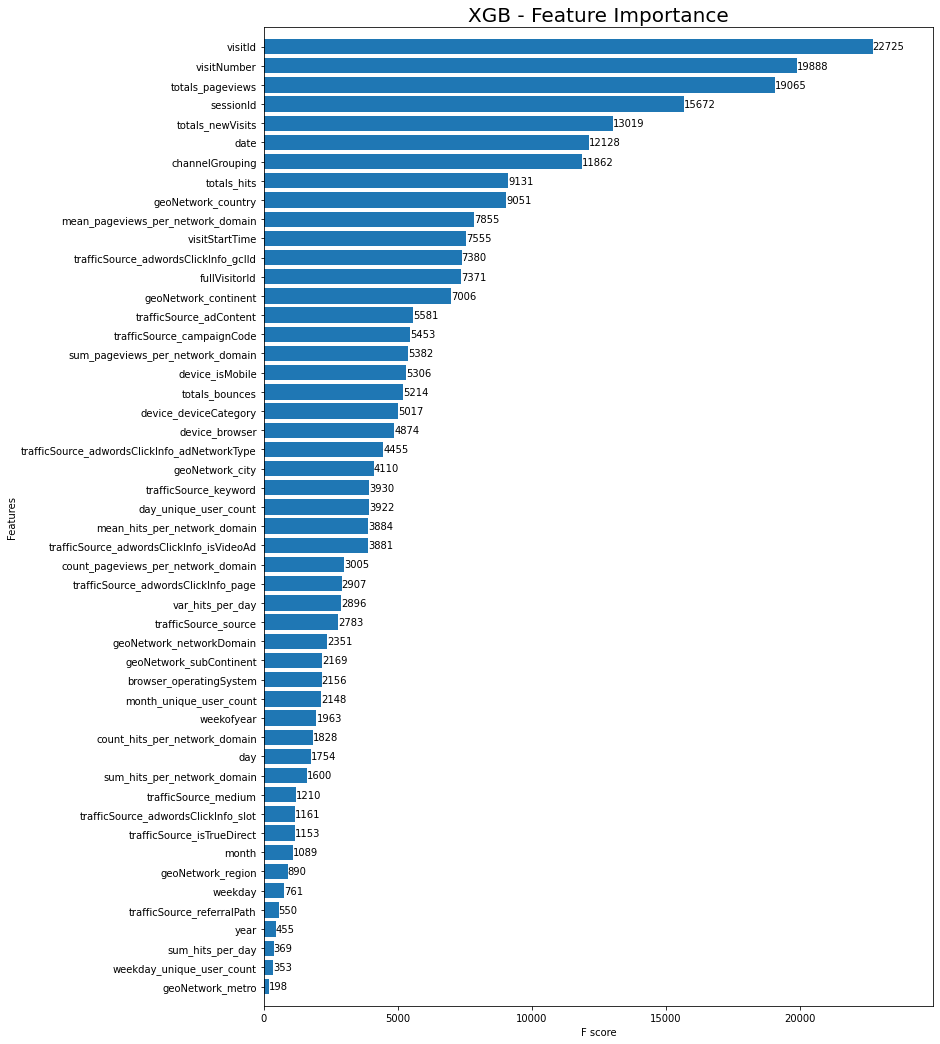

In [85]:
%matplotlib inline
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(xgb_model,max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("XGB - Feature Importance", fontsize=20)
plt.show()

#### LightGBM Regressor ####

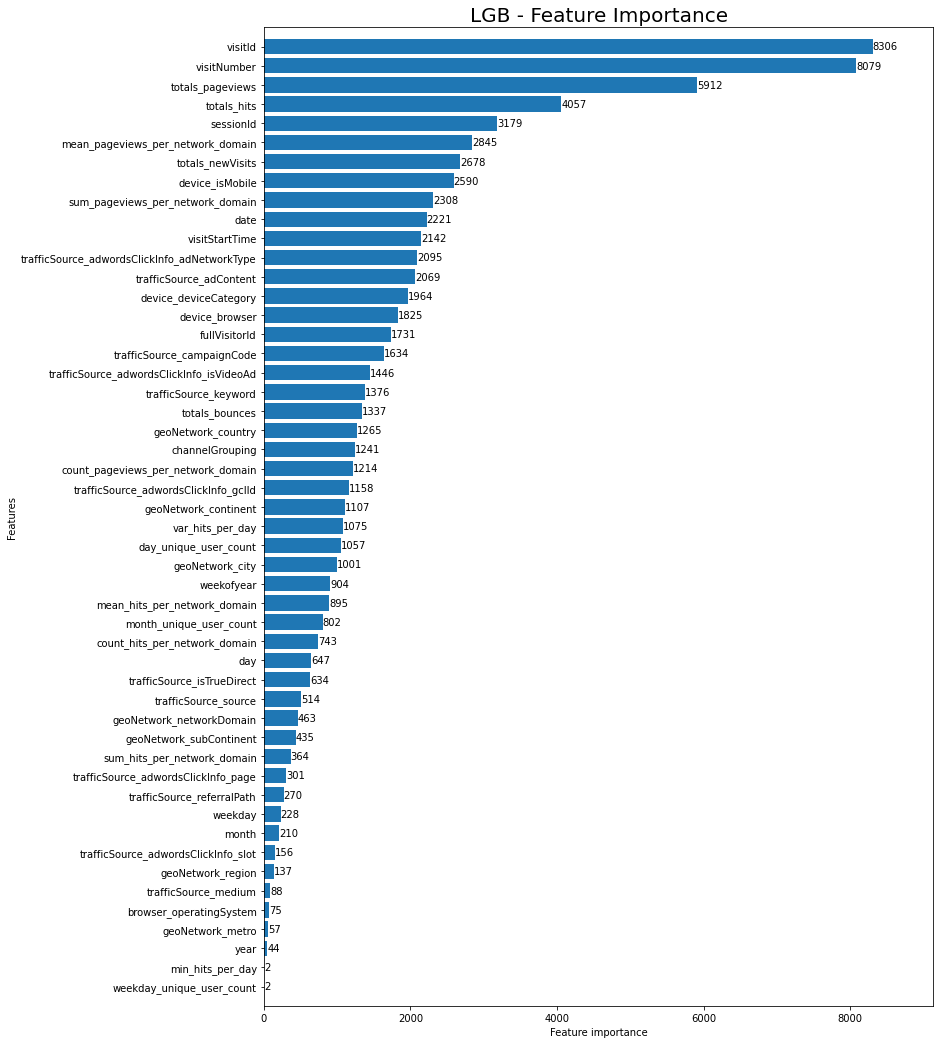

In [86]:
from lightgbm import plot_importance
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(lgb_model,max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LGB - Feature Importance", fontsize=20)
plt.show()

### Conclusion ###

As a project team the intention was to create a template that can be utilized for any ML project. The dataset that was used for this project was challenging in a way that it required a lot of data cleaning, flattening and transformation to get the data into the required format.

#### Model Pipeline ####

In this project, multiple regression and tree based models from scikit learn library were explored with various hyper parameter setting and other methods like the lightGBM. The goal of the model pipeline was to explore and examine data, identify data pre-processing methods, imputation strategies, derive features and try different feature extraction methods was to perform different experiments with different parameter setting and identify the optimized with low RMSE that can be operationalized in Production. The parameters were explored within the boundary of this problem setting using different techniques.

#### Feature Exploration and Pre-Processing ####

As part of this project a few features were engineered and included in the training dataset. The feature importance visualizations that were generated after the model training process indicate that these engineered features were part of the top 30% of high impact features and they contributed reasonably to improving the overall accuracy of the model. During additional experimentation phase, the possibility of including few other potential features that could be derived from the dataset was explored and those additional features were included in the final dataset that was used during model training. Although these features did not contribute largely to reducing the error it gave an opportunity to share ideas and methods to develop these new features. Also during feature exploration phase other imputation strategies were evaluated, attempted to identify more outliers and tried different encoding techniques for categorical variables and ultimately determined that label encoder or ordinal encoder is the best way forward. Also some of the low importance features were excluded and the model was retrained to validate if the same or better RMSE value could be achieved.

#### Outcome of Experiments ####

Multiple modeling techniques were explored as part of this project like Linear regression, gradient boosting algorithms and linear regression regularization techniques. The techniques were explored with basic parameter setting and based on the outcome of those experiments, the hyper parameters were tuned using grid search to obtain the best estimator evaluated on RMSE. Also, during grid search K-Fold cross validation of training data was used and the cross validated results were examined through a results table. The fit_intercept flag played a significant role resulting in an optimal error. As part of the different experimentations that were performed, random forest algorithm was also explored but it suffered performance issues and it seemed like it would require more iterations to converge which is why it was dropped from our results and further exploration. Although random forest was not explored, gradient boosting techniques were part of the experimentations and the best RMSE from XGBoost. The LightGBM regressor was also explored with different parameter settings but it did not produce better RMSE score than XGBoost.

In the case of XGBoost, there was improvement to the RMSE score as different tree depths, feature fraction, learning rate, number of children, bagging fraction, sub-sample were explored. There was significant improvement to the error metric when these parameters were adjusted in an intuitive way. Also, linear regression with regularization techniques were explored and although there was some improvement to the error metric compared to the basic linear regression model they did not perform better than the gradient boosting method that was explored. So, based on different explorations and experimentations a reasonably conclusion can be made that gradient boosting technique performed better for the given problem setting and generated the best RMSE score. Based on the evaluation results of XGBoost on the dataset used, the recommendation would be to test the XGBoost model with real time data and the performance of the model can be evaluated in real-time scenario too and additionally, if needed, hyper parameter tuning can be performed on the XGBoost model specifically for the real-time scenario [^9]. The feature engineering process on the dataset helped derive features with additional predictive value and a pipeline was built to reuse the same process in different modeling techniques. Five different models were tested including Linear Regression, XGBoost, Light GBM, Lasso and Ridge.